<a href="https://colab.research.google.com/github/RoozbehSanaei/deep-learning-notebooks/blob/master/cgan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[**An Introduction To Conditional GANs (CGANs)**]((https://medium.com/datadriveninvestor/an-introduction-to-conditional-gans-cgans-727d1f5bb011)
)


In [8]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

import matplotlib.pyplot as plt

import numpy as np
!mkdir images
!mkdir saved_model

mkdir: cannot create directory ‘images’: File exists
mkdir: cannot create directory ‘saved_model’: File exists


In [0]:
class CGAN():
    def __init__(self):
        # Input shape
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.num_classes = 10
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss=['binary_crossentropy'],
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise and the target label as input
        # and generates the corresponding digit of that label
        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,))
        img = self.generator([noise, label])

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated image as input and determines validity
        # and the label of that image
        valid = self.discriminator([img, label])

        # The combined model  (stacked generator and discriminator)
        # Trains generator to fool discriminator
        self.combined = Model([noise, label], valid)
        self.combined.compile(loss=['binary_crossentropy'],
            optimizer=optimizer)

In [0]:
def build_generator(self):

    model = Sequential()

    model.add(Dense(256, input_dim=self.latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(np.prod(self.img_shape), activation='tanh'))
    model.add(Reshape(self.img_shape))

    model.summary()

    noise = Input(shape=(self.latent_dim,))
    label = Input(shape=(1,), dtype='int32')
    label_embedding = Flatten()(Embedding(self.num_classes, self.latent_dim)(label))

    model_input = multiply([noise, label_embedding])
    img = model(model_input)

    return Model([noise, label], img)

CGAN.build_generator = build_generator
del build_generator

In [0]:

def build_discriminator(self):

    model = Sequential()

    model.add(Dense(512, input_dim=np.prod(self.img_shape)))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()

    img = Input(shape=self.img_shape)
    label = Input(shape=(1,), dtype='int32')

    label_embedding = Flatten()(Embedding(self.num_classes, np.prod(self.img_shape))(label))
    flat_img = Flatten()(img)

    model_input = multiply([flat_img, label_embedding])

    validity = model(model_input)

    return Model([img, label], validity)

CGAN.build_discriminator = build_discriminator
del build_discriminator

In [0]:

def train(self, epochs, batch_size=128, sample_interval=50):

    # Load the dataset
    (X_train, y_train), (_, _) = mnist.load_data()

    # Configure input
    X_train = (X_train.astype(np.float32) - 127.5) / 127.5
    X_train = np.expand_dims(X_train, axis=3)
    y_train = y_train.reshape(-1, 1)

    # Adversarial ground truths
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for epoch in range(epochs):

        # ---------------------
        #  Train Discriminator
        # ---------------------

        # Select a random half batch of images
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs, labels = X_train[idx], y_train[idx]

        # Sample noise as generator input
        noise = np.random.normal(0, 1, (batch_size, 100))

        # Generate a half batch of new images
        gen_imgs = self.generator.predict([noise, labels])

        # Train the discriminator
        d_loss_real = self.discriminator.train_on_batch([imgs, labels], valid)
        d_loss_fake = self.discriminator.train_on_batch([gen_imgs, labels], fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Train Generator
        # ---------------------

        # Condition on labels
        sampled_labels = np.random.randint(0, 10, batch_size).reshape(-1, 1)

        # Train the generator
        g_loss = self.combined.train_on_batch([noise, sampled_labels], valid)

        # Plot the progress
        print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

        # If at save interval => save generated image samples
        if epoch % sample_interval == 0:
            self.sample_images(epoch)

CGAN.train = train
del train

In [0]:

def sample_images(self, epoch):
    r, c = 2, 5
    noise = np.random.normal(0, 1, (r * c, 100))
    sampled_labels = np.arange(0, 10).reshape(-1, 1)

    gen_imgs = self.generator.predict([noise, sampled_labels])

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt,:,:,0], cmap='gray')
            axs[i,j].set_title("Digit: %d" % sampled_labels[cnt])
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig("images/%d.png" % epoch)
    plt.close()

CGAN.sample_images = sample_images
del sample_images

In [0]:
cgan = CGAN()
cgan.train(epochs=20000, batch_size=32, sample_interval=200)

images/0.png	  images/14200.png  images/18800.png  images/5400.png
images/10000.png  images/14400.png  images/19000.png  images/5600.png
images/1000.png   images/14600.png  images/19200.png  images/5800.png
images/10200.png  images/14800.png  images/19400.png  images/6000.png
images/10400.png  images/15000.png  images/19600.png  images/600.png
images/10600.png  images/15200.png  images/19800.png  images/6200.png
images/10800.png  images/15400.png  images/2000.png   images/6400.png
images/11000.png  images/15600.png  images/200.png    images/6600.png
images/11200.png  images/15800.png  images/2200.png   images/6800.png
images/11400.png  images/16000.png  images/2400.png   images/7000.png
images/11600.png  images/1600.png   images/2600.png   images/7200.png
images/11800.png  images/16200.png  images/2800.png   images/7400.png
images/12000.png  images/16400.png  images/3000.png   images/7600.png
images/1200.png   images/16600.png  images/3200.png   images/7800.png
images/12200.png  images

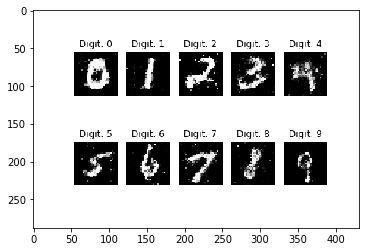

In [16]:
!ls images/*
img = plt.imread("images/19800.png")
plt.imshow(img)